*Importing necessary utilities and libraries*

In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA               
from statsmodels.tsa.statespace.sarimax import SARIMAX      
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

*Lodaing the dataset*

In [291]:
df = pd.read_csv('Apple_stocks.csv', index_col=0, parse_dates=[0])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-28,32.965000,32.987499,32.775002,32.945000,29.692596,122933200
2015-05-29,32.807499,32.862499,32.474998,32.570000,29.354616,203538000
2015-06-01,32.570000,32.847500,32.512501,32.634998,29.413195,128451200
2015-06-02,32.465000,32.665001,32.330002,32.490002,29.282515,134670400
2015-06-03,32.665001,32.735001,32.474998,32.529999,29.318565,123934000


In [292]:
df = df.asfreq('B')  # as we have data for business days
df.index

DatetimeIndex(['2015-05-28', '2015-05-29', '2015-06-01', '2015-06-02',
               '2015-06-03', '2015-06-04', '2015-06-05', '2015-06-08',
               '2015-06-09', '2015-06-10',
               ...
               '2020-05-14', '2020-05-15', '2020-05-18', '2020-05-19',
               '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-25',
               '2020-05-26', '2020-05-27'],
              dtype='datetime64[ns]', name='Date', length=1305, freq='B')

In [293]:
df.shape

(1305, 6)

In [294]:
df.isna().sum()

Open         46
High         46
Low          46
Close        46
Adj Close    46
Volume       46
dtype: int64

In [295]:
df = df.ffill().bfill()   # replacing null values (can also drop those values)

# null values arise due to bank holidays

In [296]:
df.index

DatetimeIndex(['2015-05-28', '2015-05-29', '2015-06-01', '2015-06-02',
               '2015-06-03', '2015-06-04', '2015-06-05', '2015-06-08',
               '2015-06-09', '2015-06-10',
               ...
               '2020-05-14', '2020-05-15', '2020-05-18', '2020-05-19',
               '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-25',
               '2020-05-26', '2020-05-27'],
              dtype='datetime64[ns]', name='Date', length=1305, freq='B')

In [297]:
years = df.index.year.nunique()
avg_bdays = len(df) // years
print("Average business days per year:", avg_bdays)

Average business days per year: 217


*Data Visualization*

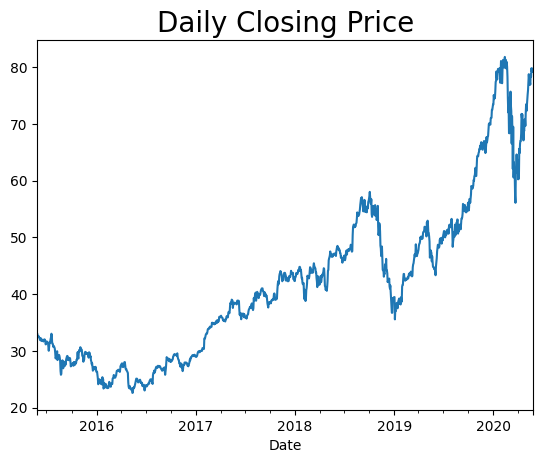

In [298]:
# daily closing price plot
df['Close'].plot()
plt.title("Daily Closing Price", size=20)
plt.show()

<Axes: xlabel='Date'>

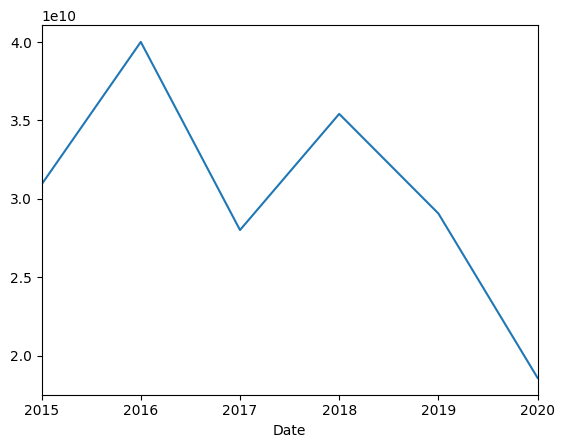

In [299]:
# plot of yearly volume
df.resample('Y').sum()['Volume'].plot()

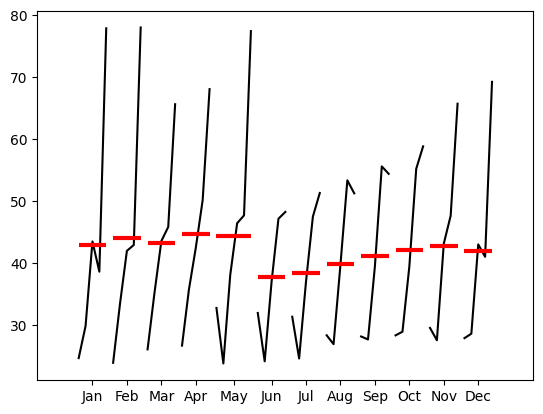

In [300]:
# plot of monthly seasonality
month_plot(df['Close'].resample('M').mean())
plt.show()

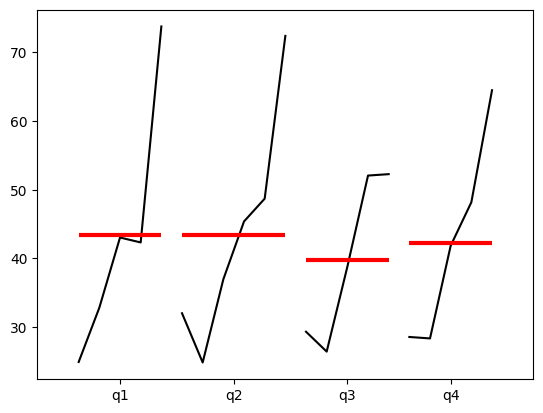

In [301]:
# plot of quarterly seasonality
quarter_plot(df['Close'].resample('Q').mean())
plt.show()

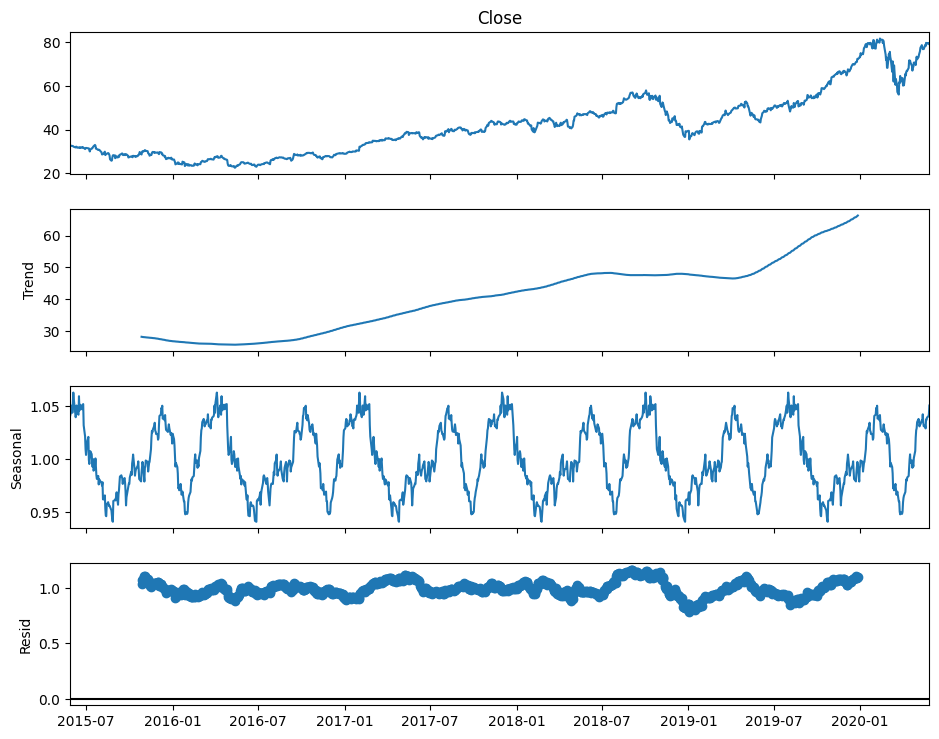

In [302]:
# plot of seasonal decomposition
decomposition = seasonal_decompose(df['Close'], model='mul', period=avg_bdays)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

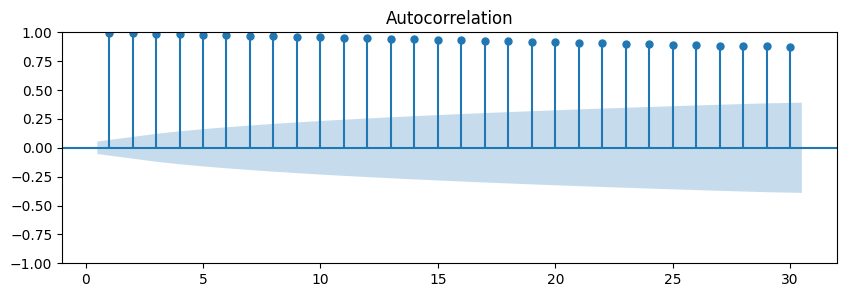

In [303]:
# plot of ACF
fig, ax = plt.subplots(figsize = (10, 3))
plot_acf(df['Close'], lags=30, ax=ax, zero=False)
plt.show()

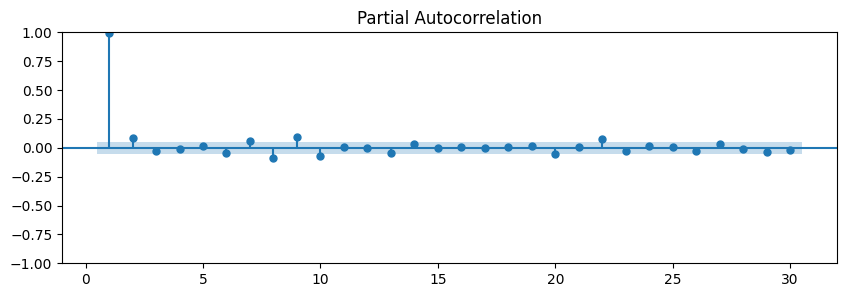

In [304]:
# plot of PACF
fig, ax = plt.subplots(figsize = (10, 3))
plot_pacf(df['Close'], lags=30, ax=ax, zero=False)
plt.show()

*Holt - Winters Method*

In [305]:
# function to plot data and compute the errors.
def plot_n_error(train, test, predictions, title):

    # plot of train, test and predictions
    plt.plot(train, label="Train")
    plt.plot(test, label="Test")
    plt.plot(predictions, label=title)
    plt.legend()
    plt.show()

    # calculating the errors
    mae = mean_absolute_error(test, predictions)
    rmse = mean_squared_error(test, predictions, squared=False)
    mape = mean_absolute_percentage_error(test, predictions)

    print(f"The MAE is {mae:.2f}")
    print(f"The RMSE is {rmse:.2f}")
    print(f"The MAPE is {100 * mape:.2f} %")

In [306]:
# targeting the closing price of stocks.
split_index = int(len(df) * 0.8)    # 80:20 train-test split
train = df.iloc[:split_index, 3]
test = df.iloc[split_index:, 3]

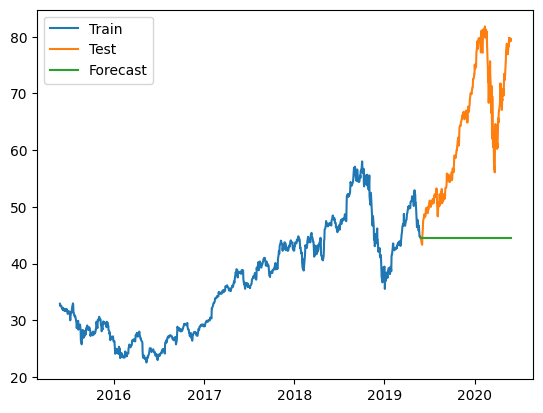

The MAE is 18.92
The RMSE is 21.79
The MAPE is 27.70 %


In [307]:
# simple exponential smoothing - controls level
model_simple = SimpleExpSmoothing(train).fit()
predictions_simple = model_simple.forecast(len(test))
predictions_simple.index = test.index

plot_n_error(train, test, predictions_simple, "Forecast")

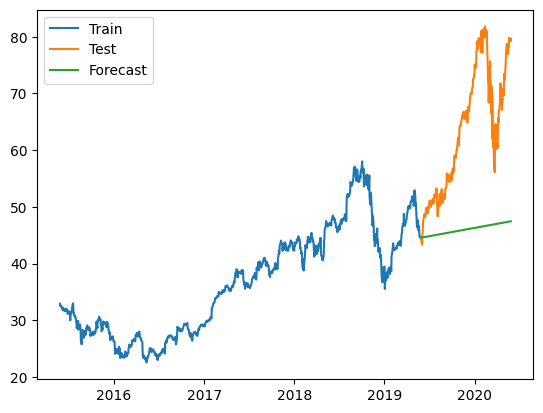

The MAE is 17.46
The RMSE is 20.18
The MAPE is 25.54 %


In [308]:
# double exponential smoothing - controls trend
model_double = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
predictions_double = model_double.forecast(len(test))
predictions_double.index = test.index

plot_n_error(train, test, predictions_double, "Forecast")

d:\Python 3.11.6\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


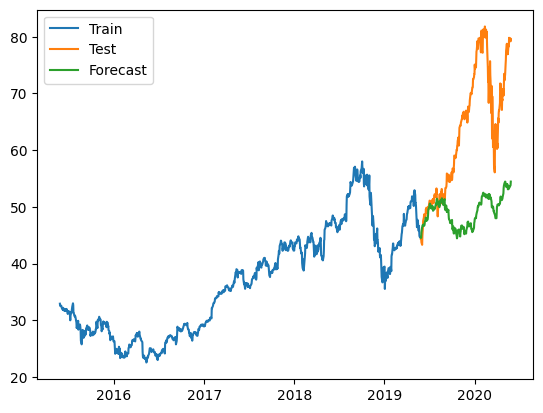

The MAE is 14.34
The RMSE is 17.48
The MAPE is 20.54 %


In [309]:
# triple exponential smoothing (Holt Winters method) - controls seasonality
model_triple = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=avg_bdays).fit()  
predictions_triple = model_triple.forecast(len(test))
predictions_triple.index = test.index

plot_n_error(train, test, predictions_triple, "Forecast")

*Augmented Dickey - Fuller Test*

In [310]:
def adf_test(series):
    result = adfuller(series)
    print(f'p-value: {result[1]}')

    if result[1] < 0.05:
        print("\nConclusion: Reject the null hypothesis (H0), the series is likely stationary.")
    else:
        print("\nConclusion: Fail to reject the null hypothesis (H0), the series is likely non-stationary.")

In [311]:
# to check for stationarity of the series
series = df['Close']

adf_test(series)

p-value: 0.9627192743020794

Conclusion: Fail to reject the null hypothesis (H0), the series is likely non-stationary.


In [312]:
# making the series stationary by differencing
differenced_series = series.diff()

adf_test(differenced_series[1:])

p-value: 2.54127467009285e-08

Conclusion: Reject the null hypothesis (H0), the series is likely stationary.


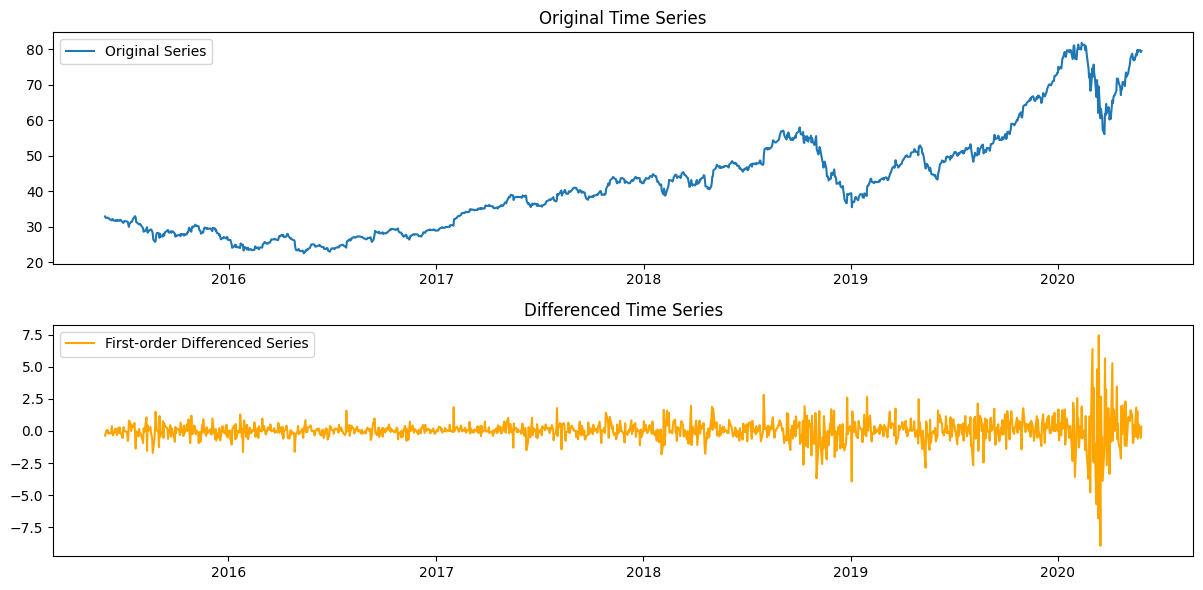

In [313]:
# plot of original and differenced series
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(series, label='Original Series')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(differenced_series, label='First-order Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()
plt.tight_layout()
plt.show()

*Implementing ARIMA and ARIMAX*

In [314]:
train.head()

Date
2015-05-28    32.945000
2015-05-29    32.570000
2015-06-01    32.634998
2015-06-02    32.490002
2015-06-03    32.529999
Freq: B, Name: Close, dtype: float64

In [315]:
test.head()

Date
2019-05-29    44.345001
2019-05-30    44.575001
2019-05-31    43.767502
2019-06-03    43.325001
2019-06-04    44.910000
Freq: B, Name: Close, dtype: float64

In [316]:
model_arima = auto_arima(train, seasonal=False, trace=True)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1881.052, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1882.579, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1882.537, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1879.417, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1879.980, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.629 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -938.709
Date:                Wed, 25 Jun 2025   AIC                           1879.417
Time:                        21:23:32   BIC                           1884.367
Sample:                    05-28-2015   HQIC                          1881.294
                         - 05-28-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3542      0.008     46.458      0.000       0.339       0.369
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              1783.50
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               3.63   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

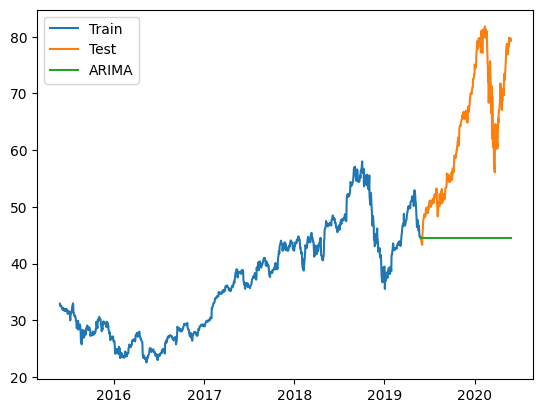

The MAE is 18.92
The RMSE is 21.79
The MAPE is 27.70 %


In [317]:
predictions_arima = model_arima.predict(n_periods=len(test))

plot_n_error(train, test, predictions_arima, "ARIMA")

In [318]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [319]:
exog_train, exog_test = df.iloc[:split_index, 0:3], df.iloc[split_index:, 0:3]

In [320]:
exog_train.head()

,Open,High,Low
Date,,,
2015-05-28,32.965000,32.987499,32.775002
2015-05-29,32.807499,32.862499,32.474998
2015-06-01,32.570000,32.847500,32.512501
2015-06-02,32.465000,32.665001,32.330002
2015-06-03,32.665001,32.735001,32.474998


In [321]:
exog_test.head()

,Open,High,Low
Date,,,
2019-05-29,44.105000,44.837502,44.000000
2019-05-30,44.487499,44.807499,44.167500
2019-05-31,44.057499,44.497501,43.747501
2019-06-03,43.900002,44.480000,42.567501
2019-06-04,43.860001,44.957500,43.630001


In [322]:
model_arimax = auto_arima(train, X=exog_train, seasonal=False, trace=True)   
model_arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-364.316, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-360.435, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-359.358, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-359.463, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-359.609, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-358.570, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-350.434, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-365.242, Time=0.87 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-357.933, Time=0.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-348.357, Time=0.45 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-362.484, Time=0.44 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-364.116, Time=0.52 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-364.813, Time=0.57 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-363.465, Time=1.06 sec

Best model:  ARIMA(2,0,3)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 191.621
Date:                Wed, 25 Jun 2025   AIC                           -365.242
Time:                        21:23:40   BIC                           -320.685
Sample:                    05-28-2015   HQIC                          -348.343
                         - 05-28-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.5518      0.017    -33.202      0.000      -0.584      -0.519
High           0.7858      0.017     45.825      0.000       0.752       0.819
Low            0.7660      0.013     60.471      0.000       0.741       0.791
ar.L1         -0.1284      0.161     -0.796      0.426      -0.445       0.188
ar.L2          0.7840      0.151      5.204      0.000       0.489       1.079
ma.L1          0.1634      0.162      1.011      0.312      -0.153       0.480
ma.L2         -0.8421      0.146     -5.749      0.000      -1.129      -0.555
ma.L3         -0.0263      0.025     -1.039      0.299      -0.076       0.023
sigma2         0.0405      0.001     33.402      0.000       0.038       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               352.82
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

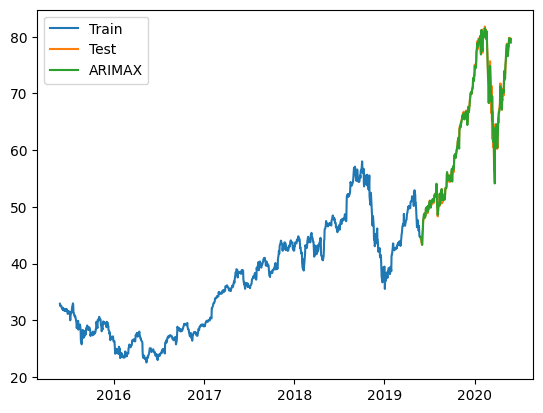

The MAE is 0.35
The RMSE is 0.57
The MAPE is 0.56 %


In [323]:
predictions_arimax = model_arimax.predict(n_periods=len(test), X=exog_test)

plot_n_error(train, test, predictions_arimax, "ARIMAX")